# Data Science Capstone - Identifying the Best Neighborhoods to Live in Seattle

In [1]:
# pyplot for plotting charts and graphs
%matplotlib inline
import matplotlib.pyplot as plt

# import the pandas library for data analysis
import pandas as pd

# library to handle data in a vectorized manner
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# library to convert an address into latitude and longitude values
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

## Extract and Format Seattle Neighborhood Information

### Create a dataframe that consists of 4 columns: Neighborhood, District, Latitude, Longitude

In [2]:
# define the dataframe columns
column_names = ['Neighborhood', 'District', 'Latitude', 'Longitude'] 

# instantiate the dataframe
seattle_neighborhoods = pd.DataFrame(columns=column_names)
seattle_neighborhoods

Empty DataFrame
Columns: [Neighborhood, District, Latitude, Longitude]
Index: []

### Scrap Wikipedia to obtain Seattle Neighborhood Data

In [3]:
# scrape the table in the wikipedia page that contains the list of neighborhoods in Seattle
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
seattle_neighborhoods_table = pd.read_html(str(table))[0]
seattle_neighborhoods_table.head()

Unnamed: 0         Neighborhood name Within larger district  \
0           1             North Seattle                Seattle   
1           2                 Broadview      North Seattle[42]   
2           3               Bitter Lake      North Seattle[42]   
3           4  North Beach / Blue Ridge      North Seattle[42]   
4           5                Crown Hill      North Seattle[42]   

                    Annexed[41]  Locator map  Street map  Image  \
0                       Various          NaN         NaN    NaN   
1                      1954[43]          NaN         NaN    NaN   
2                      1954[43]          NaN         NaN    NaN   
3            1940,[43] 1954[43]          NaN         NaN    NaN   
4  1907,[47] 1952,[43] 1954[43]          NaN         NaN    NaN   

                                         Notes  
0  North of the Lake Washington Ship Canal[42]  
1                                         [44]  
2                                         [45]  
3                                         [46]  
4                                         [48]

### Clean and Transform the data into a pandas dataframe

In [4]:
import re

# iterate through each row in the table to extract the neighborhood and district information
for row_index, row in seattle_neighborhoods_table.iterrows():
    
    neighborhood = row[1] # second column is neighborhood information
    neighborhood = re.sub("[\(\[].*?[\)\]]", "", neighborhood) # remove in-text citation (e.g. [153])
    neighborhood = neighborhood.replace(' /',',') # format the list of neighborhoods to be comma-separated
    
    district = row[2] # third column is district information
    district = re.sub("[\(\[].*?[\)\]]", "", district) # remove in-text citation (e.g. [42])
    district = district.replace(' /',',') # format the list of districts to be comma-separated

    seattle_neighborhoods = seattle_neighborhoods.append({'Neighborhood': neighborhood,
                                                          'District': district}, ignore_index=True) 

In [13]:
# print the resulting seattle neighborhood dataframe
seattle_neighborhoods.head()

Neighborhood       District Latitude Longitude
1                Broadview  North Seattle      NaN       NaN
2              Bitter Lake  North Seattle      NaN       NaN
3  North Beach, Blue Ridge  North Seattle      NaN       NaN
4               Crown Hill  North Seattle      NaN       NaN
5                Greenwood  North Seattle      NaN       NaN

In [14]:
# print the number of neighborhoods
print('There are {} neighborhoods in dataframe.'.format(seattle_neighborhoods.shape[0]))

There are 109 neighborhoods in dataframe.


In [11]:
# remove neighborhoods that are overlapped with other neighborhoods
overlapped_neighborhoods = ['North Seattle','Northgate', 'Lake City', 'University District', 'Ballard', 'Central Seattle', 'Magnolia', 'Queen Anne', 'Capitol Hill', 'Madison Park', 'Lake Union', 'Downtown', 'Central Area', 'Seattle', 'South End', 'Rainier Valley', 'Seward Park', 'Beacon Hill', 'Industrial District', 'West Seattle', 'Delridge']
seattle_neighborhoods.drop(seattle_neighborhoods[seattle_neighborhoods['Neighborhood']
                                                 .isin(overlapped_neighborhoods)].index, inplace=True)

# print the resulting number of neighborhoods
print('There are {} neighborhoods in dataframe.'.format(seattle_neighborhoods.shape[0]))

There are 109 neighborhoods in dataframe.


### Export the dataframe to a CSV file and Create a download link for a copy

In [ ]:
# export the seattle neighborhoods dataframe to a CSV file and create a download link for a copy

import base64
from IPython.display import HTML

def create_download_link( df, title = "Download Seattle neighborhoods CSV file", filename = "seattle_neighborhoods.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(seattle_neighborhoods)

### Import Seattle Neighborhoods CSV with Latitude/Longitude data

In [26]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_787e258c07b441369f0ff1977e32d5ff = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='0zQbQxO1c5ZzYd00NxRcrGRDisPh7XjyRp34PK8yu0g-',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_787e258c07b441369f0ff1977e32d5ff.get_object(Bucket='capstone-donotdelete-pr-yobxnl2tuewsyb',Key='seattle_neighborhoods_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


Unnamed: 0 Neighborhood       District   Latitude   Longitude
0           1    Broadview  North Seattle  47.722320 -122.360407
1           2  Bitter Lake  North Seattle  47.726236 -122.348764
2           3  North Beach  North Seattle  47.696210 -122.392362
3           4   Crown Hill  North Seattle  47.694715 -122.371459
4           5    Greenwood  North Seattle  47.690981 -122.354877

In [28]:
# drop unnamed column
seattle_neighborhoods_coord = df_data_1.drop(columns=['Unnamed: 0'])
seattle_neighborhoods_coord.head()

Neighborhood       District   Latitude   Longitude
0    Broadview  North Seattle  47.722320 -122.360407
1  Bitter Lake  North Seattle  47.726236 -122.348764
2  North Beach  North Seattle  47.696210 -122.392362
3   Crown Hill  North Seattle  47.694715 -122.371459
4    Greenwood  North Seattle  47.690981 -122.354877

### Define Foursquare Credentials and Version

In [39]:
CLIENT_ID = 'YCJXEKNS5EQNYITIEWGTJC14S5PDSNFWAFI312LCGHC0VFKA' # Foursquare ID
CLIENT_SECRET = 'UN5GZBFQQU1K0H3PBRC0SY0PQBW2U0REJWOP3PQ5UQWLPGRV' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Create a function to explore neighborhoods

In [40]:
import requests

# set default radius to 500 and limit the number of venues returned by Foursquare API to 100
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)        
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Run the above function to explore Seattle neighborhoods and create a new dataframe

In [41]:
seattle_venues = getNearbyVenues(names=seattle_neighborhoods_coord['Neighborhood'],
                                 latitudes=seattle_neighborhoods_coord['Latitude'],
                                 longitudes=seattle_neighborhoods_coord['Longitude']
                                )

### Display the shape and the resulting dataframe

In [42]:
print(seattle_venues.shape)
seattle_venues.head()

(2618, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Broadview               47.72232             -122.360407   
1    Broadview               47.72232             -122.360407   
2    Broadview               47.72232             -122.360407   
3    Broadview               47.72232             -122.360407   
4    Broadview               47.72232             -122.360407   

                  Venue  Venue Latitude  Venue Longitude   Venue Category  
0  Wicked Good Grinders       47.719657      -122.355966       Food Truck  
1            Chada Thai       47.719663      -122.355114  Thai Restaurant  
2   Broadview Tap House       47.719337      -122.356152         Beer Bar  
3        Domino's Pizza       47.719942      -122.355088      Pizza Place  
4                Redbox       47.719600      -122.355579      Video Store

### Analyze each neighborhood

In [43]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe as first column
seattle_onehot.insert(0, 'neighborhood', seattle_venues['Neighborhood'])

# display resulting dataframe
seattle_onehot.head()

neighborhood  ATM  Accessories Store  African Restaurant  Airport Service  \
0    Broadview    0                  0                   0                0   
1    Broadview    0                  0                   0                0   
2    Broadview    0                  0                   0                0   
3    Broadview    0                  0                   0                0   
4    Broadview    0                  0                   0                0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Art Gallery  ...  \
0                    0             0         0       0            0  ...   
1                    0             0         0       0            0  ...   
2                    0             0         0       0            0  ...   
3                    0             0         0       0            0  ...   
4                    0             0         0       0            0  ...   

   Water Park  Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0           0           0           0         0          0            0   
1           0           0           0         0          0            0   
2           0           0           0         0          0            0   
3           0           0           0         0          0            0   
4           0           0           0         0          0            0   

   Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0              0            0    0            0  
1              0            0    0            0  
2              0            0    0            0  
3              0            0    0            0  
4              0            0    0            0  

[5 rows x 303 columns]

### Group rows by Neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
seattle_grouped = seattle_onehot.groupby('neighborhood').mean().reset_index()
seattle_grouped.head()

neighborhood       ATM  Accessories Store  African Restaurant  \
0          Adams  0.000000                0.0                 0.0   
1     Alki Point  0.000000                0.0                 0.0   
2  Arbor Heights  0.000000                0.0                 0.0   
3       Belltown  0.000000                0.0                 0.0   
4    Bitter Lake  0.037037                0.0                 0.0   

   Airport Service  American Restaurant  Antique Shop  Aquarium  Arcade  \
0              0.0             0.000000           0.0       0.0     0.0   
1              0.0             0.000000           0.0       0.0     0.0   
2              0.0             0.000000           0.0       0.0     0.0   
3              0.0             0.014493           0.0       0.0     0.0   
4              0.0             0.000000           0.0       0.0     0.0   

   Art Gallery  ...  Water Park  Waterfront  Whisky Bar  Wine Bar  Wine Shop  \
0     0.000000  ...         0.0         0.0         0.0       0.0        0.0   
1     0.000000  ...         0.0         0.0         0.0       0.0        0.0   
2     0.000000  ...         0.0         0.0         0.0       0.0        0.0   
3     0.014493  ...         0.0         0.0         0.0       0.0        0.0   
4     0.000000  ...         0.0         0.0         0.0       0.0        0.0   

   Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0          0.0            0.0          0.0  0.0          0.0  
1          0.0            0.0          0.0  0.0          0.0  
2          0.0            0.0          0.0  0.0          0.0  
3          0.0            0.0          0.0  0.0          0.0  
4          0.0            0.0          0.0  0.0          0.0  

[5 rows x 303 columns]

### Use elbow method to identify the optimal k for k-means clustering

In [63]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

seattle_grouped_clustering = seattle_grouped.drop('neighborhood', 1)

# run k-means for different values of k to identify the best k for clustering
Sum_of_squared_distances = []
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(seattle_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

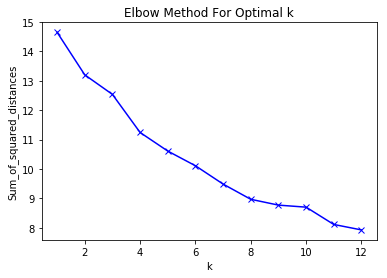

In [64]:
# use the elbow method to identify the optimal k for k-means
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Run k-means to cluster the neighborhoods

In [66]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 8, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 7, 4, 1, 4, 1, 4, 1, 1, 1, 1, 3, 1, 7, 1, 4, 1, 1, 1,
       4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 8, 1, 1, 9, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 9, 3, 0, 1, 1, 1,
       5, 7, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1], dtype=int32)

### Write a function to sort the venues in descending order

In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create a new dataframe and display the top 10 venues for each neighborhood

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue        2nd Most Common Venue  \
0          Adams           Bus Station                      Dog Run   
1     Alki Point                 Beach                   Lighthouse   
2  Arbor Heights                   Spa  Professional & Other Places   
3       Belltown                 Hotel                       Bakery   
4    Bitter Lake  Fast Food Restaurant         Gym / Fitness Center   

  3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
0              Gym Pool          Soccer Field                     Park   
1        Baseball Field      Baseball Stadium       Frozen Yogurt Shop   
2           Zoo Exhibit                  Fair       Falafel Restaurant   
3                   Bar    Seafood Restaurant  New American Restaurant   
4                  Food    Seafood Restaurant           Sandwich Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Food           Flower Shop           Fish Market   
1    Falafel Restaurant        Farmers Market  Fast Food Restaurant   
2        Farmers Market  Fast Food Restaurant                 Field   
3      Sushi Restaurant           Pizza Place         Deli / Bodega   
4             Pet Store          Noodle House     Mobile Phone Shop   

        9th Most Common Venue      10th Most Common Venue  
0           Fish & Chips Shop           Food & Drink Shop  
1                       Field  Financial or Legal Service  
2  Financial or Legal Service           Fish & Chips Shop  
3               Movie Theater        Marijuana Dispensary  
4           Hotpot Restaurant                       Hotel

### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [76]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge data to add latitude/longitude for each neighborhood
seattle_merged = seattle_neighborhoods_coord
seattle_merged = seattle_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head()

Neighborhood       District   Latitude   Longitude  Cluster Labels  \
0    Broadview  North Seattle  47.722320 -122.360407               1   
1  Bitter Lake  North Seattle  47.726236 -122.348764               1   
2  North Beach  North Seattle  47.696210 -122.392362               8   
3   Crown Hill  North Seattle  47.694715 -122.371459               1   
4    Greenwood  North Seattle  47.690981 -122.354877               1   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  Furniture / Home Store          Antique Shop       Thai Restaurant   
1    Fast Food Restaurant  Gym / Fitness Center                  Food   
2                   Beach                  Park        Scenic Lookout   
3             Coffee Shop         Deli / Bodega        Sandwich Place   
4             Coffee Shop                   Bar    Mexican Restaurant   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0              Beer Bar           Video Store      Sushi Restaurant   
1    Seafood Restaurant        Sandwich Place             Pet Store   
2           Zoo Exhibit            Eye Doctor                  Fair   
3          Burger Joint           Flower Shop    Mexican Restaurant   
4           Pizza Place             Bookstore                   Spa   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Pizza Place     Convenience Store            Food Truck   
1          Noodle House     Mobile Phone Shop     Hotpot Restaurant   
2    Falafel Restaurant        Farmers Market  Fast Food Restaurant   
3            Taco Place  Fast Food Restaurant         Grocery Store   
4      Toy / Game Store           Event Space               Brewery   

  10th Most Common Venue  
0      Food & Drink Shop  
1                  Hotel  
2                  Field  
3              Pet Store  
4                Theater

### Get the geographical coordinates of Seattle

In [77]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


### Visualize the resulting cluster

In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, venue in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'], seattle_merged['1st Most Common Venue']):
    label = folium.Popup(str(poi) + ': Most Common Venue - ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Download and Format Seattle Crime Data Set

### Download 2020 crime data set published by Seattle Police Department 

In [5]:
# download 2020 crime data set published by Seattle Police Department and read the dataset to pandas dataframes
df_incidents_jan = pd.read_csv('https://public.tableau.com/vizql/w/SPD_Public_TEST/v/CrimeDashboard/vud/sessions/C74FF650B95246AC813FADCCFD885F2A-0:0/views/9834487940925278445_17750790518434820238?csv=true')
df_incidents_feb = pd.read_csv('https://public.tableau.com/vizql/w/SPD_Public_TEST/v/CrimeDashboard/vud/sessions/C74FF650B95246AC813FADCCFD885F2A-0:0/views/9834487940925278445_17750790518434820238?csv=true')
df_incidents_mar = pd.read_csv('https://public.tableau.com/vizql/w/SPD_Public_TEST/v/CrimeDashboard/vud/sessions/C74FF650B95246AC813FADCCFD885F2A-0:0/views/9834487940925278445_17750790518434820238?csv=true')

# Stack the dataFrames on top of each other
df_incidents = pd.concat([df_incidents_jan, df_incidents_feb, df_incidents_mar], axis=0)

# display the first 5 rows in the dataset
df_incidents.head()

Incomplete Month SeaStat Category  SeaStat Offense Beat          MCPP  \
0   Complete Month     Violent Crime         Robbery   E2  CAPITOL HILL   
1   Complete Month     Violent Crime         Robbery   E2  CAPITOL HILL   
2   Complete Month    Property Crime   Larceny-Theft   E1  CAPITOL HILL   
3   Complete Month    Property Crime   Larceny-Theft   E1  CAPITOL HILL   
4   Complete Month    Property Crime   Larceny-Theft   E1  CAPITOL HILL   

       Offense Offense Code   Offense ID Offense Start DateTime Precinct  
0      Robbery          120  12487506383   1/29/2020 5:43:00 PM     East  
1      Robbery          120  12171936788   1/18/2020 1:05:00 AM     East  
2  Shoplifting          23C  12497952865   1/29/2020 7:50:00 PM     East  
3  Shoplifting          23C  12157245447    1/4/2020 1:15:00 PM     East  
4  Shoplifting          23C  12158480613    1/4/2020 4:50:00 PM     East

In [6]:
# print the number of incidents in dataset
print('There are {} incidents in Seattle in Jan-Mar 2020.'.format(df_incidents.shape[0]))

There are 9788 incidents in Seattle in Jan-Mar 2020.


### Create a dataframe with neighborhood, category, offense information

In [7]:
# create a new dataframe with only the relevant information (neighborhood, category, offense)
seattle_crimes = pd.concat([df_incidents['MCPP'], df_incidents['SeaStat Category '], df_incidents['SeaStat Offense']], axis=1, keys=['Neighborhood', 'Category', 'Offense'])
seattle_crimes.head()

Neighborhood        Category        Offense
0  CAPITOL HILL   Violent Crime        Robbery
1  CAPITOL HILL   Violent Crime        Robbery
2  CAPITOL HILL  Property Crime  Larceny-Theft
3  CAPITOL HILL  Property Crime  Larceny-Theft
4  CAPITOL HILL  Property Crime  Larceny-Theft

### Clean the dataset

In [8]:
# drop incidents with unknown neighborhoods
seattle_crimes.drop( seattle_crimes[ seattle_crimes['Neighborhood'] == 'UNKNOWN' ].index , inplace=True)

# capitalize the first letter of each word in neighborhood
seattle_crimes['Neighborhood'] = seattle_crimes['Neighborhood'].str.title()

seattle_crimes.head()

Neighborhood        Category        Offense
0  Capitol Hill   Violent Crime        Robbery
1  Capitol Hill   Violent Crime        Robbery
2  Capitol Hill  Property Crime  Larceny-Theft
3  Capitol Hill  Property Crime  Larceny-Theft
4  Capitol Hill  Property Crime  Larceny-Theft

### Group crimes by neighborhood and category

In [9]:
# group crimes by neighborhood and category
seattle_crimes_grouped = seattle_crimes.groupby(['Neighborhood','Category'],as_index=False).count()
seattle_crimes_grouped.head()

Neighborhood        Category  Offense
0  Alaska Junction  Property Crime      120
1  Alaska Junction   Violent Crime        8
2             Alki  Property Crime       32
3             Alki   Violent Crime        1
4    Ballard North  Property Crime      132

### Find neighborhoods with most violent crimes

In [10]:
# filter crimes to retrieve only violent crimes
violent_crimes = seattle_crimes_grouped.loc[seattle_crimes_grouped['Category'] == 'Violent Crime']
violent_crimes.head()

Neighborhood       Category  Offense
1  Alaska Junction  Violent Crime        8
3             Alki  Violent Crime        1
5    Ballard North  Violent Crime       13
7    Ballard South  Violent Crime       28
9         Belltown  Violent Crime       28

In [11]:
# sort neighborhoods with most violent crimes
top_violent_crimes = violent_crimes.sort_values('Offense',ascending=False)
top_violent_crimes = top_violent_crimes.head(n=5)
top_violent_crimes

Neighborhood       Category  Offense
28               Downtown Commercial  Violent Crime       95
15                      Capitol Hill  Violent Crime       67
99                       Slu/Cascade  Violent Crime       46
79                         Northgate  Violent Crime       46
19  Chinatown/International District  Violent Crime       39

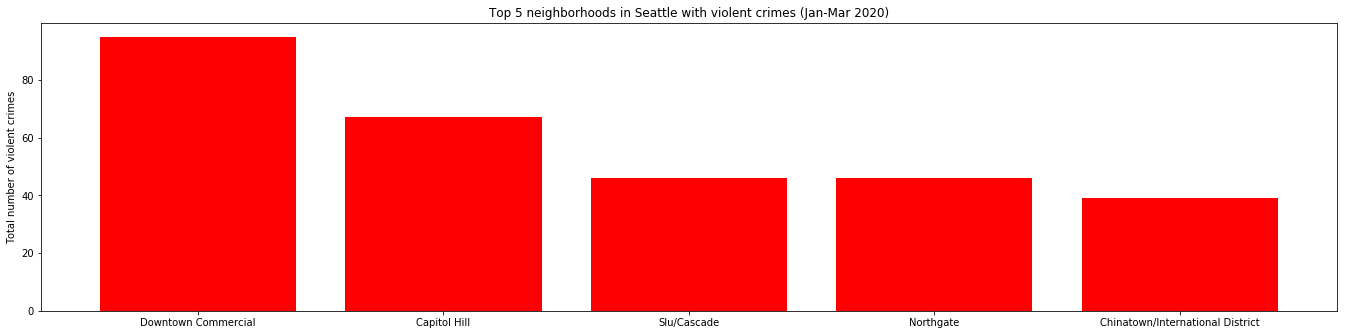

In [13]:
# create a bar chart showing the top neighborhoods with most violent crimes
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar(top_violent_crimes['Neighborhood'],top_violent_crimes['Offense'],color=['red'])

plt.title('Top 5 neighborhoods in Seattle with violent crimes (Jan-Mar 2020)')
plt.ylabel('Total number of violent crimes')

plt.show()

### Find neighborhoods with least violent crimes

In [91]:
# sort neighborhoods with least violent crimes
least_violent_crimes = violent_crimes.sort_values('Offense',ascending=True)
least_violent_crimes = least_violent_crimes.head(n=5)
least_violent_crimes

Neighborhood       Category  Offense
3              Alki  Violent Crime        1
38          Genesee  Violent Crime        1
83     Pigeon Point  Violent Crime        1
81    Phinney Ridge  Violent Crime        1
31  Eastlake - West  Violent Crime        1

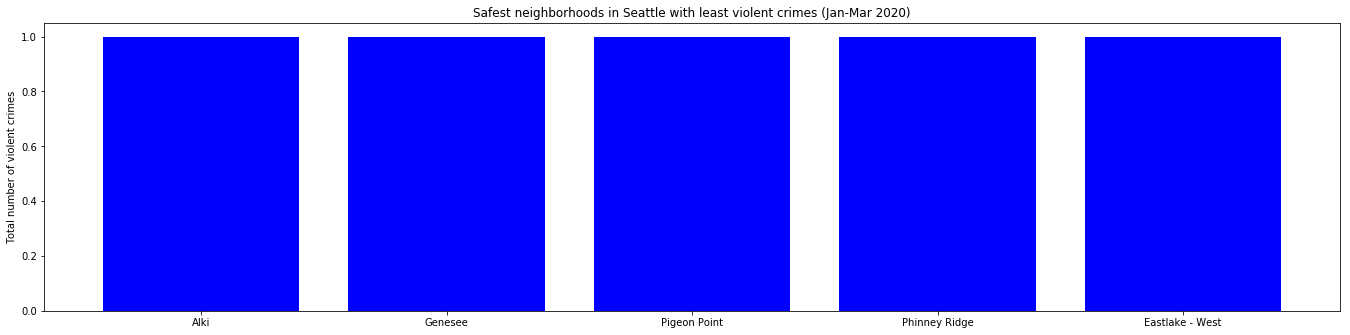

In [92]:
# create a bar chart showing the top neighborhoods with most violent crimes
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar(least_violent_crimes['Neighborhood'],least_violent_crimes['Offense'],color=['blue'])

plt.title('Safest neighborhoods in Seattle with least violent crimes (Jan-Mar 2020)')
plt.ylabel('Total number of violent crimes')

plt.show()

### Find total number of crimes in each neighborhood 

In [14]:
# get total number of crimes in each neighborhood
total_crimes_by_neighborhood = seattle_crimes.groupby(['Neighborhood'],as_index=False).count()
total_crimes_by_neighborhood.head()

Neighborhood  Category  Offense
0  Alaska Junction       128      128
1             Alki        33       33
2    Ballard North       145      145
3    Ballard South       343      343
4         Belltown       147      147

### Find neighborhoods with most crimes

In [15]:
# sort neighborhoods with most crimes
top_neighborhoods_with_crimes = total_crimes_by_neighborhood.sort_values('Offense',ascending=False)
top_neighborhoods_with_crimes = top_neighborhoods_with_crimes.head(n=5)
top_neighborhoods_with_crimes

Neighborhood  Category  Offense
14  Downtown Commercial       476      476
45           Queen Anne       441      441
7          Capitol Hill       415      415
56           University       406      406
41            Northgate       371      371

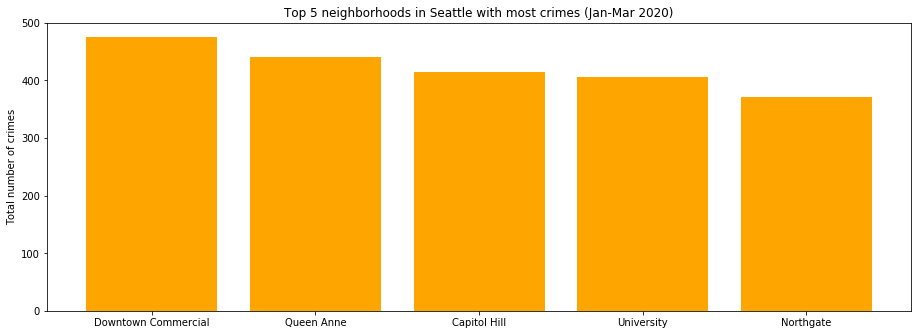

In [16]:
# create a bar chart showing the top neighborhoods with most crimes
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(top_neighborhoods_with_crimes['Neighborhood'],top_neighborhoods_with_crimes['Offense'], color=['orange'])

plt.title('Top 5 neighborhoods in Seattle with most crimes (Jan-Mar 2020)')
plt.ylabel('Total number of crimes')

plt.show()

### Find neighborhoods with least crimes

In [85]:
# sort neighborhoods with least crimes
neighborhoods_with_least_crimes = total_crimes_by_neighborhood.sort_values('Offense',ascending=True)
neighborhoods_with_least_crimes = neighborhoods_with_least_crimes.head(n=5)
neighborhoods_with_least_crimes

Neighborhood  Category  Offense
43              Pigeon Point         3        3
13  Commercial Harbor Island         3        3
12       Commercial Duwamish         3        3
15           Eastlake - East         8        8
29              Madison Park        13       13

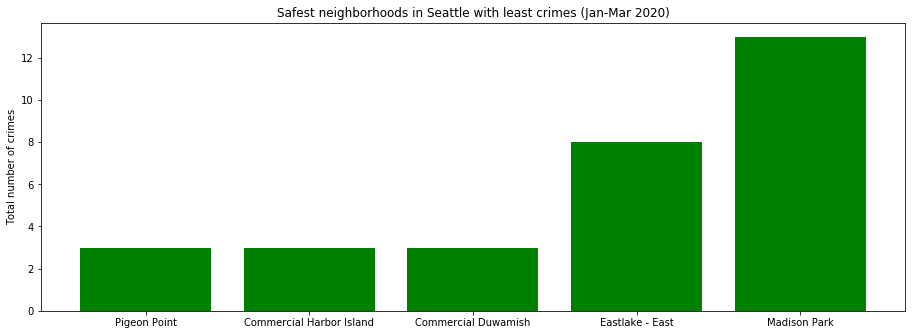

In [86]:
# create a bar chart showing the neighborhoods with least crimes
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(neighborhoods_with_least_crimes['Neighborhood'],neighborhoods_with_least_crimes['Offense'], color=['green'])

plt.title('Safest neighborhoods in Seattle with least crimes (Jan-Mar 2020)')
plt.ylabel('Total number of crimes')

plt.show()

### Get the geographical coordinates of Seattle

In [17]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


### Create a map of Seattle and superimpose the locations of the crimes onto the map

In [19]:
# download seattle neighborhoods geojson file
!wget --quiet https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson -O seattle_neighborhoods.json

seattle_geo = 'seattle_neighborhoods.json'

In [24]:
# create a map of seattle
choropleth_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map to show the total number of crimes in each neighborhood
choropleth_map.choropleth(
    geo_data=seattle_geo,
    data=total_crimes_by_neighborhood,
    columns=['Neighborhood', 'Offense'],
    key_on='feature.properties.nhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Incidents in Seattle (Jan-Mar 2020)'
)

# display map
choropleth_map

In [23]:
# create a map of seattle
choropleth_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map to show the number of violent crimes in each neighborhood
choropleth_map.choropleth(
    geo_data=seattle_geo,
    data=violent_crimes,
    columns=['Neighborhood', 'Offense'],
    key_on='feature.properties.nhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Violent Crime Incidents in Seattle (Jan-Mar 2020)'
)

# display map
choropleth_map